
The goal of this note book is to build an optimization class / pipeline that can optimize the model of the car. The goal is that the resulting mathematical model of the car matches the characteristics of the real car as closely as possible. This will help for two reasons:
1. We need to develop controllers that control the steering and throttle/brakes. If we have a perfect model than we can develop the controller based on that model and it will transition perfectly onto the car. The worse the model is, the more time we will need to spend manually tuning the controller which is tedious/time-consuming.
2. We need to plan a path for the car to follow. This path needs to account for how hard the car can accelerate, brake, and turn but also how the hard braking, accelerating, and turning will impact motor and tire temperatures. If we plan this properly we should cross the finish line with a motor about to overheat and tires about to fail. If we mess it up we leave time on the table (go too slow) or we break the car before crossing the finish line.

Specifically it should model these things:
1. Linear Speed
    - This one should be pretty straight forward
    - Inputs:
        - Current speed: Measured from the GPS/IMU position estimate and recorded by the open log
        - Last PWM Speed Command: Captured by the Arduino Mini-Pro and recorded by the open log
        - New PWM Speed Command: Captured by the Arduino Mini-Pro and recorded by the open log
    - Outputs:
        - Acceleration: Measured by the GPS/IMU and recorded by the open log
2. Steering
    - This is likely the most complicated
    - Inputs:
        - Current Speed: Measured from the GPS/IMU position estimate and recorded by the open log
        - Current Heading: Measured by the GPS/IMU and recorded by the open log
        - Current Heading Rate: Measured by the GPS/IMU and recorded by the open log
        - Current Steering Angle: This will need to be approximated - or possibly just ignored and we map from PWM to heading rate?
        - Current Steering Rate: This will need to be approximated - or possibly just ignored and we map from PWM to heading rate?
        - Last Steering PWM Command: Captured by the Arduino Mini-Pro and recorded by the open log
        - New Steering PWM Command: Captured by the Arduino Mini-Pro and recorded by the open log
    - Outputs:
        - New Steering Angle
        - New Steering Rate
        - New Heading Angle
        - New Heading Rate
3. Motor Temperature
    * This one seems pretty simple if the underlying model is ~right
    - Inputs: 
        - Current Temperature - logged by ESC
        - Ambient Temperature - Manual capture and recording
        - Current Vehicle Speed - Measured from the GPS/IMU position estimate and recorded by the open log
        - PWM command - Captured by the Arduino Mini-Pro and recorded by the open log
    - Outputs:
        - New Temperature - logged by ESC
4. Tire Temperature
    - This one seems pretty simple if the underlying model is ~right
    - Inputs:
        - Current Temperature: measured with contactless IR sensor
        - Tire Forces: 
            - Down Force:
                - Car weight: Measure on a scale and record
                - Aerodynamic downforce: need to find a way to either measure this based on ride height OR model it based on ability to turn?
            - Acceleration/Braking Force:
                - Measure from IMU and record on open log
            - Cornering Force / Perpendicular Force:
                - Measure from IMU and record on open log
        - Car Speed:
            - Measured from IMU and record on Open Log
        - Ambient Temperature:
            - Measure and record manually
        - Ground Temperature: 
            - Measure and record manually
    - Outputs:
        - New Temperature: measured with contactless IR sensor


Implied todos:
1. Get a few digital thermometers that record the air temp and ground temp
2. Time synch the ESC data log and the openlog
3. Find a way to measure height of the car at front and rear
    - $19.95 - SparkFun Distance Sensor - 1.3 Meter, VL53L4CD (Qwiic)
    - https://www.sparkfun.com/products/18993

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
log_df = pd.read_pickle("laguna_seca_lap_df.pkl")

3. Motor Temperature
    * This one seems pretty simple if the underlying model is ~right
    - Inputs: 
        - Current Temperature - logged by ESC
        - Ambient Temperature - Manual capture and recording
        - Current Vehicle Speed - Measured from the GPS/IMU position estimate and recorded by the open log
        - PWM command - Captured by the Arduino Mini-Pro and recorded by the open log
    - Outputs:
        - New Temperature - logged by ESC
    - Params to optimize:
        - Specific Heat Coefficient
        - Convective heat Coefficient
            - This is multiplied by surface area so can be lumped together
        - Internal Resistanace

In [92]:
from Motor import Motor
from MotorParams import MotorParams

c1717_1650_params = MotorParams()
c1717_1650_params.name = 'Castle 1717-1650KV'
c1717_1650_params.kv = 1650.0
c1717_1650_params.max_battery_cells = 8.0
c1717_1650_params.max_specd_rpm = 56000.0
c1717_1650_params.resistance = 0.0856092660801802 # pulled from Raz Shifrin's speed secrets via screen capture
c1717_1650_params.diam = 0.0476 # m - 1.87 in
c1717_1650_params.length = 0.0851 # m - 3.35 in
c1717_1650_params.length_scalar_for_fins = 2.0
c1717_1650_params.max_temp = 82.222 # deg C - 180F
c1717_1650_params.specific_heat_coeff = 0.89 # J/(g * deg C) - specific heat capacity of aluminum - 0.385 J/(g * deg C) for copper
c1717_1650_params.mass = 548.0 # grams for Castle Creations 171
c1717_1650_params.convective_heat_coeff = 200.0 # convective heat transfer coefficient of the process - W / (m^2 C) - 200 is an ~upper limit for a cylinder
        
c1717_1650_params.print()

MotorParams: Name:  Castle 1717-1650KV
MotorParams: KV:  1650.0
MotorParams: Max Battery Cells:  8.0
MotorParams: Max Voltage:  0.0  V
MotorParams: Max spec'd RPM:  56000.0
MotorParams: KT:  0.0
MotorParams: Resistance:  0.0856092660801802  Ohms
MotorParams: Diameter:  0.0476  m
MotorParams: Length:  0.0851  m
MotorParams: Length Scalar for Fins:  2.0
MotorParams: Max Temp:  82.222  C
MotorParams: Mass:  548.0  g
MotorParams: Specific Heat Coeff:  0.89  J/(g * deg C)
MotorParams: Convective Heat Coeff:  200.0  w/(m^2 deg C)


In [93]:
motor = Motor()
motor.read_params(c1717_1650_params)
motor.calc_vals()
motor.print()

Motor: Name:  Castle 1717-1650KV
Motor: KV:  1650.0
Motor: Max Battery Cells:  8.0
Motor: Max Voltage:  29.6  V
Motor: Max spec'd RPM:  56000.0
Motor: KT:  0.8193939393939393
Motor: Resistance:  0.0856092660801802  Ohms
Motor: Diameter:  0.0476  m
Motor: Length:  0.0851  m
Motor: Length Scalar for Fins:  2.0
Motor: Surface Area:  0.029010723200309584  m^2
Motor: Max Temp:  82.222  C
Motor: Mass:  548.0  g
Motor: Specific Heat Coeff:  0.89  J/(g * deg C)
Motor: Convective Heat Coeff:  200.0  w/(m^2 deg C)
Motor: Current:  0.0  A
Motor: Voltage:  0.0  g
Motor: Torque:  0.0  Nm
Motor: Speed:  0.0  RPM
Motor: Temperature:  21.12  C


In [139]:
#https://pymoo.org/getting_started/part_3.html
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.pso import PSO # particle swarm
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize



class MotorTemperatureOptmization(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=1,
                         n_ieq_constr=0,
                         xl=np.array([0,100]),
                         xu=np.array([10.0,500]))

    def _evaluate(self, x, out, *args, **kwargs):
        # x = np.array([motor.resistance, # internal resistance
        #       motor.specific_heat_coeff, # specific heat coeff
        #       motor.convective_heat_coeff, # convective heat transfer coeff
        #       ])
        timestep = 0.01
        motor_temp = log_df["Motor Temp (C)"].iloc[0]
        ambient_temp = 21.12
        err = 0.0
        # temps = []
        for i in range(len(log_df["Motor Temp (C)"])):
            current = log_df["Motor Current (A)"].iloc[i]
            heat_generated = motor.resistance * current**2
            dT = motor_temp - ambient_temp # temperature difference between the surface and the fluid - C
            heat_expelled = x[1] * motor.surface_area * dT # rate of heat expulsion - W - J/s
            heat_diff = heat_generated - heat_expelled
            motor_temp = (heat_diff*timestep) / (motor.mass * x[0]) + motor_temp
            err += abs(log_df["Motor Temp (C)"].iloc[i] - motor_temp)
        
        f1 = err# / len(log_df["Motor Temp (C)"])
        out["F"] = [f1]
        out["G"] = []


problem = MotorTemperatureOptmization()

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

alg2 = PSO() # PSO can't be used on multiobjective optimization


termination = get_termination("n_gen", 40)

res = minimize(problem,
               alg2,#algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

x = res.X
F = res.F

r_x = np.array([#motor.resistance, # internal resistance
              motor.specific_heat_coeff, # specific heat coeff
              motor.convective_heat_coeff, # convective heat transfer coeff
              ])

print("F: ", F)
print("Recorded X: ", r_x)
print("Estimate X: ", x)
print("Diff: ", abs(x - r_x))

n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       25 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  1.192436E+05 |  4.600377E+03
     2 |       50 |  0.29962 |       2 |  0.5923 |  2.04133 |  1.95867 |  1.006027E+05 |  4.600377E+03
     3 |       75 |  0.12955 |       3 |  0.4828 |  2.04063 |  1.97639 |  7.832242E+04 |  4.600377E+03
     4 |      100 |  0.06080 |       3 |  0.4385 |  2.03158 |  1.98548 |  6.264320E+04 |  4.600377E+03
     5 |      125 | -2.7E-02 |       3 |  0.3835 |  2.02262 |  1.99598 |  4.473626E+04 |  3.848159E+03
     6 |      150 | -8.3E-03 |       3 |  0.3948 |  2.01310 |  2.00405 |  3.590660E+04 |  3.848159E+03
     7 |      175 | -1.6E-02 |       3 |  0.3898 |  2.00444 |  2.01458 |  2.899518E+04 |  3.848159E+03
     8 |      200 | -1.3E-02 |       3 |  0.3919 |  1.99506 |  2.02978 |  2.010720E+04 |  3.848159E+03
     9 |      225 | -6.4E-03 |       3 |  0.3960 |  1.98306 |  2.04147 | 

Recorded X:  [  0.89 200.  ]
Estimate X:  [  0.88999227 200.01297528]
Diff:  [7.72764776e-06 1.29752769e-02]


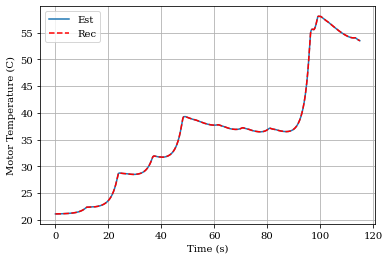

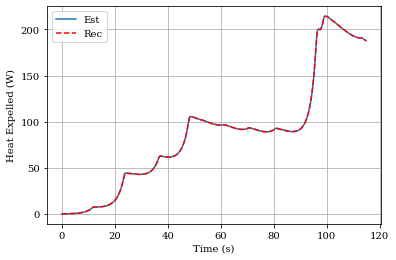

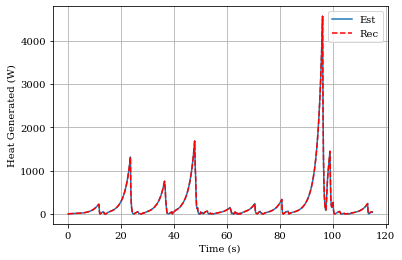

In [142]:
r_x = np.array([#motor.resistance, # internal resistance
              motor.specific_heat_coeff, # specific heat coeff
              motor.convective_heat_coeff, # convective heat transfer coeff
              ])

print("Recorded X: ", r_x)
print("Estimate X: ", x)
print("Diff: ", abs(x - r_x))

timestep = 0.01
motor_temp = log_df["Motor Temp (C)"].iloc[0]
ambient_temp = 21.12
temps = []
currents = []
hes = []
hgs = []
for i in range(len(log_df["Motor Temp (C)"])):
    current = log_df["Motor Current (A)"].iloc[i]
    heat_generated = motor.resistance * current**2
    heat_expelled = x[1] * motor.surface_area * (motor_temp - ambient_temp) # rate of heat expulsion - W - J/s
    heat_diff = heat_generated - heat_expelled
    motor_temp = (heat_diff*timestep) / (motor.mass * x[0]) + motor_temp
    temps.append(motor_temp)
    hes.append(heat_expelled)
    hgs.append(heat_generated)

plt.plot(log_df['Time (s)'], temps, label="Est")
plt.plot(log_df['Time (s)'], log_df["Motor Temp (C)"], 'r--', label="Rec")
plt.ylabel("Motor Temperature (C)")
plt.xlabel("Time (s)")
plt.legend()
plt.grid()
plt.show()

plt.plot(log_df['Time (s)'], hes, label="Est")
plt.plot(log_df['Time (s)'], log_df["Motor Heat Expelled (W)"], 'r--', label="Rec")
plt.ylabel("Heat Expelled (W)")
plt.xlabel("Time (s)")
plt.legend()
plt.grid()
plt.show()

plt.plot(log_df['Time (s)'], hgs, label="Est")
plt.plot(log_df['Time (s)'], log_df["Motor Heat Generated (W)"], 'r--', label="Rec")
plt.ylabel('Heat Generated (W)')
plt.xlabel("Time (s)")
plt.legend()
plt.grid()
plt.show()
